In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


from nirs4all.operators.transformations import Gaussian, SavitzkyGolay, StandardNormalVariate, Haar, MultiplicativeScatterCorrection
from nirs4all.operators.models.cirad_tf import nicon, customizable_nicon
from nirs4all.pipeline.config import PipelineConfigs
from nirs4all.dataset.dataset_config import DatasetConfigs
from nirs4all.pipeline.runner import PipelineRunner
import json
from sklearn.ensemble import GradientBoostingRegressor

pipeline = [
    MinMaxScaler(feature_range=(0.1, 0.8)),
    MultiplicativeScatterCorrection,
    ShuffleSplit(n_splits=3),
    {"y_processing": MinMaxScaler},
    {"model": PLSRegression(15)},
    {"model": PLSRegression(10)},
    {"model": RandomForestRegressor(n_estimators=100)},
    {"model": ElasticNet()},
    {"model": SVR(kernel='rbf', C=1.0, epsilon=0.1)},
    {"model": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=500)},
    {"model": GradientBoostingRegressor(n_estimators=100)},
    {"model": nicon,
     "train_params": {
                # Final training parameters
                "epochs": 500,
                "patience": 50,
                "batch_size": 500,
                # "cyclic_lr": True,
                # "step_size": 20,
                "lr": 0.001,
                "verbose": 0  # 0=silent, 1=progress bar, 2=one line per epoch
            },
    },

]

# create pipeline config
config = PipelineConfigs(pipeline)

# path = ['../../sample_data/regression', '../../sample_data/classification', '../../sample_data/binary']
path = '../../sample_data/regression'
dataset_config_obj = DatasetConfigs(path)

# Runner setup with spinner enabled (default is True, but let's be explicit)
runner = PipelineRunner(save_files=False, show_spinner=True, verbose=2)
print("🔄 Running pipeline with spinner enabled - watch for loading animations during model training!")
predictions, results = runner.run(config, dataset_config_obj)

🔄 Running pipeline with spinner enabled - watch for loading animations during model training!
🚀 Starting pipeline run with 1 pipeline configuration(s) on 1 dataset configuration(s) (1 total runs).
✅ Loaded dataset 'regression' with 130 training and 59 test samples.
📊 Dataset: regression
Features (samples=189, sources=1):
- Source 0: (189, 1, 2151), processings=['raw'], min=-0.265, max=1.436, mean=0.466, var=0.149)
Targets: (samples=189, targets=1, processings=['numeric'])
- numeric: min=1.33, max=128.31, mean=30.779
Indexes:
- "train", ['raw']: 130 samples
- "test", ['raw']: 59 samples
🚀 Starting pipeline config_bc79abf3 on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', 'params': {'feature_range': [0.1, 0.8]}, '_runtime_instance': MinMaxScaler(feature_r

✅ nicon_73 - test: mse=0.0094↓ (mae: 0.0697)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🏆 Best for config: PLSRegression_step5_fold1 - mse=121.6545↓
✅ Pipeline config_bc79abf3 completed successfully on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------
🏆 Best from this run: fold (config_bc79abf3_PLSRegression_step5_fold1_test) - mse=121.6545↓
🥇 Best overall: fold (config_bc79abf3_PLSRegression_step5_fold1_test) - mse=121.6545↓


Best PLSRegression: PLSRegression (partition: test_fold_2) - RMSE: 11.702382, R²: 0.212125, MAE: 8.911673
Best RandomForestRegressor: RandomForestRegressor (partition: test_fold_1) - RMSE: 20.017978, R²: -0.549602, MAE: 16.858908
Best ElasticNet: ElasticNet (partition: test_fold_2) - RMSE: 14.378818, R²: -0.189475, MAE: 12.383984
Best SVR: SVR (partition: test_fold_2) - RMSE: 12.869786, R²: 0.047091, MAE: 11.624199
Best MLPRegressor: MLPRegressor (partition: test_fold_2) - RMSE: 14.234975, R²: -0.165795, MAE: 11.775845
Best GradientBoostingRegressor: GradientBoostingRegressor (partition: test_fold_1) - RMSE: 18.573000, R²: -0.333963, MAE: 16.566674
Best nicon: nicon (partition: test_fold_2) - RMSE: 13.204253, R²: -0.003082, MAE: 11.048798


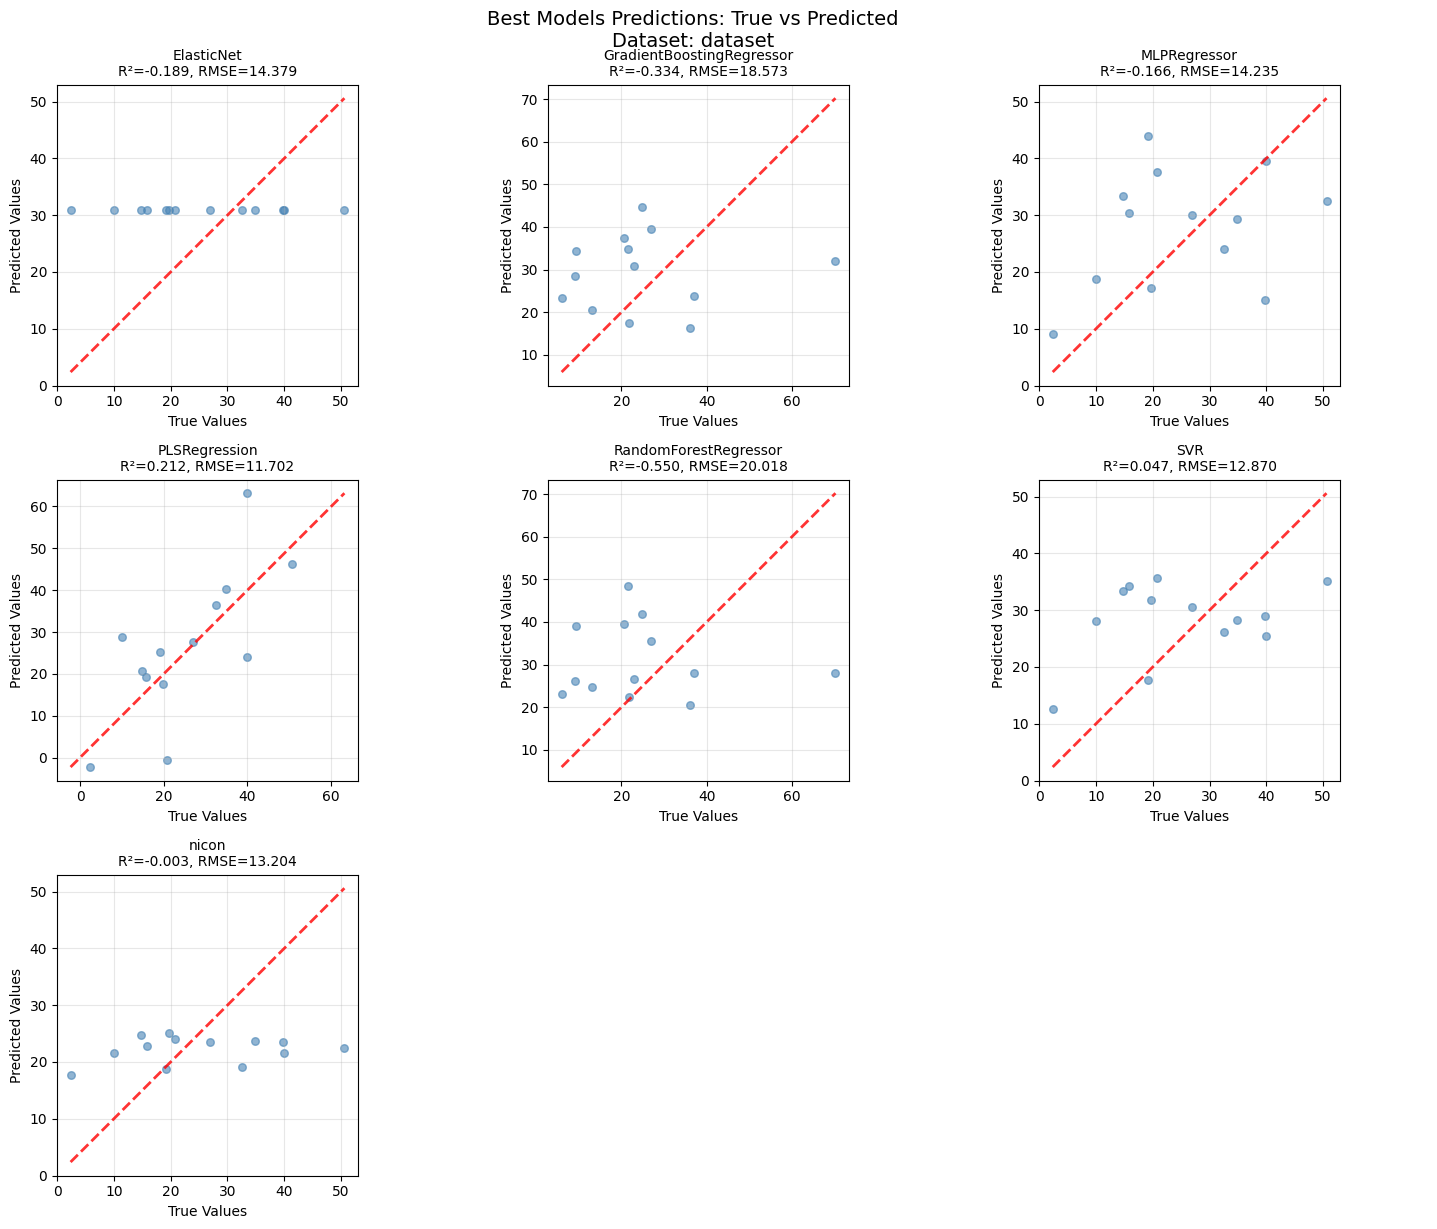

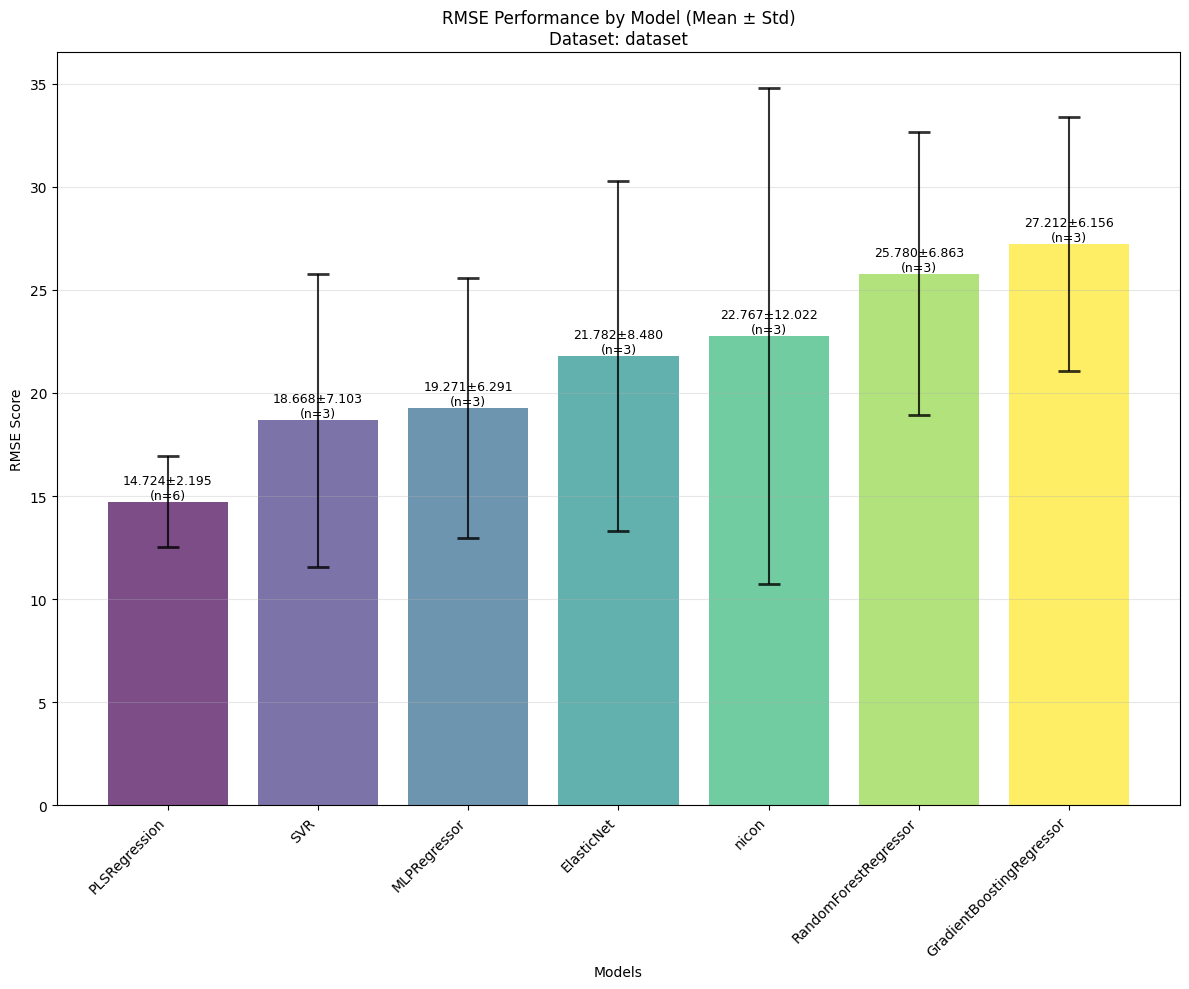

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_analyzer import PredictionAnalyzer

# global_predictions, run_predictions = results[0]
analyzer = PredictionAnalyzer(predictions)

best = analyzer.get_top_k(k=5, metric='rmse', partition_type='test')
for i, model in enumerate(best, 1):
    print(f"{i}. {model['canonical_model']} (partition: {model['partition_type']}) - RMSE: {model['metrics']['rmse']:.6f}, R²: {model['metrics']['r2']:.6f}, MAE: {model['metrics']['mae']:.6f}")

fig = analyzer.plot_top_k_comparison(k=5, metric='rmse', partition_type='test')
plt.show()